# Learning Burgers' equation with an adversary

In [1]:
import sys
if False: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else: # Local
    root = './'
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda:3')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [90]:
import importlib
import util
importlib.reload(util)
from util import *

In [6]:
dataname = "burgers"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

In [55]:
loss_L2 = torch.nn.MSELoss()
def train_it(dataset, model, disc,
             use_L2=False, use_disc=True,
             learning_rate = 1e-1, batch_size=20, print_param=False,
             Npast=1, Nfuture=1):
    """
    Training loop for a given dataset, pre-initialized model, and pre-
    initialized discriminator. The training loop is set up for advserial 
    training and/or L2 training, but will only optimize the discriminator if it 
    is needed.

    print_param shows the value of the first layer, which is intended to show 
    the convergence to the FDM stencil.
    """
    optim_model = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optim_disc  = torch.optim.Adam(disc.parameters(), lr=learning_rate)

    Nepoch = 1000
    Nbatch = batch_size
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,3))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        # Do one step
        y_pred = model(xx)+xx
        # Step the discriminator
        if use_disc:
            L_D = -0.5*(1.0 - disc(y_pred,xx).mean() + disc(yy,xx).mean())
            # I was afraid of round-error; the location of this maximum is the same.
            # The results did not change; this does change the relative scaling
            # between the discriminator loss and the MSE loss.
            #L_D =  disc(y_pred,xx).sum() - disc(yy,xx).sum()
            optim_disc.zero_grad()
            L_D.backward(retain_graph=True)
            optim_disc.step()
        else:
            L_D = torch.tensor(0)

        # Step the model
        if use_disc and not use_L2:
            #L_G = - disc(y_pred,xx).sum()
            L_G = - 0.5*disc(y_pred,xx).mean()
        if use_L2 and not use_disc:
            L_G = loss_L2(y_pred,yy)
        if use_L2 and use_disc:
            #L_G = - disc(y_pred,xx).sum() + loss_L2(y_pred,yy)
            L_G = - 0.5*disc(y_pred,xx).mean() + loss_L2(y_pred,yy)
        optim_model.zero_grad()
        L_G.backward()
        optim_model.step()
        
        #yy[:,:,1:-1]
        
        if e%Nprint == Nprint-1:
            L2 = loss_L2(y_pred,yy)
            print(e, L_D.item(),L2.item(), end='')
            if print_param:
                print( list(model.parameters())[0].cpu().detach().numpy(),end='' )
            print()
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss_L2(yyt,yt_pred)
            L2 = loss_L2(y_pred,yy)
            losses[e//Nsave,0] = L_D.item()
            losses[e//Nsave,1] = L2.item()
            losses[e//Nsave,2] = test_err.item()
    return losses

In [76]:
stash = {}

In [83]:
for use_L2,use_disc in [ (True,False), (True,True) ]:
    key = f"{use_L2}_{use_disc}"
    try:
        entry = stash[key]
        print("Resuming training of ",key)
    except KeyError:
        entry = {"model":LeakyDeepStencil(Nx,3,5,3,"ReLU").to(device),
                "disc":ConditionalDiscriminatorConv(Nx,1).to(device),
                "results":np.empty((0,3))}
        print("Training new ",key)
    model,disc,results = entry['model'],entry['disc'],entry['results']
    tr_res = train_it(dataset,model,disc, learning_rate=1.0e-3, batch_size=50,
                    use_L2 = use_L2, use_disc= use_disc,
                    print_param=False)
    results = np.append(results, tr_res, axis=0)
    stash[key] = {'model':model,
                'disc':disc,
                'results':results}
with open(root+f"/gan_data_{dataname}.pkl","wb") as f:
    torch.save(stash,f)

Resuming training of  True_False
7274 0 0.00037314032670110464
14549 0 0.0006411350914277136
21824 0 0.00965720135718584
29099 0 0.0015784414717927575
36374 0 0.008753948844969273
43649 0 9.908709034789354e-05
50924 0 0.0013332599774003029
58199 0 0.0004954563919454813
65474 0 0.00020531272457446903
72749 0 0.0003627869882620871
Resuming training of  True_True
7274 -0.49990972876548767 0.0007614995120093226
14549 -0.49997979402542114 0.000326260196743533
21824 -0.49999505281448364 0.0012317548971623182
29099 -0.4999944269657135 0.000807335483841598
36374 -0.4998488426208496 0.0016243066638708115
43649 -0.4999988079071045 0.00028957115137018263
50924 -0.5249989032745361 0.009895133785903454
58199 -0.500005841255188 0.0003536417498253286
65474 -0.49999532103538513 0.0006040699081495404
72749 -0.4999426305294037 0.00041809165850281715


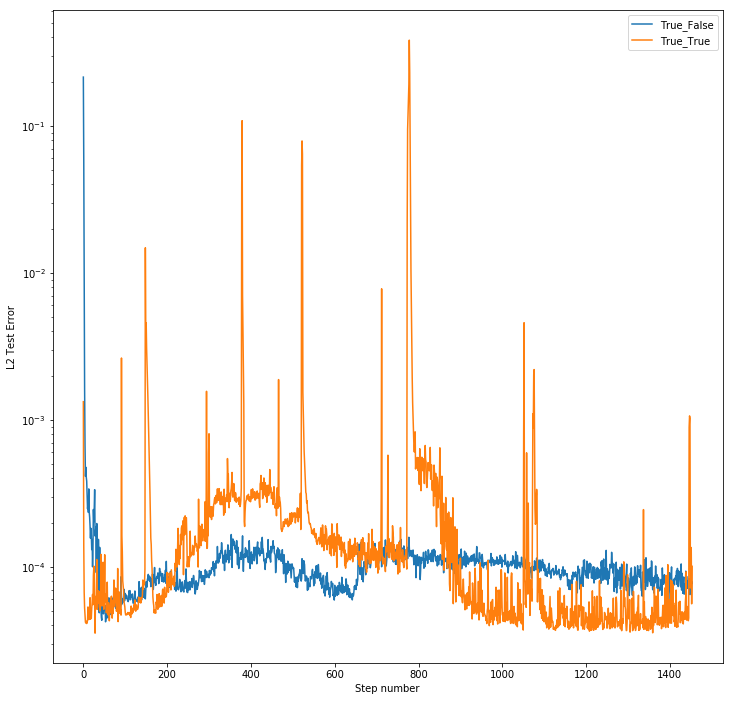

In [84]:
plt.figure(figsize=(12,12))
alpha_channel=1
for N,S in stash.items():
    #plt.semilogy(S['results'][:,1],label=f"{N}, L2")
    plt.semilogy(S['results'][:,2],label=N,alpha=alpha_channel)
    #alpha_channel = 0.25
    #label = None
plt.legend()
#plt.ylim((2e-5,1e-3))
plt.xlabel('Step number')
plt.ylabel('L2 Test Error')
plt.savefig(root+'/paper/burgers_loss.png',dpi=300)
plt.show()

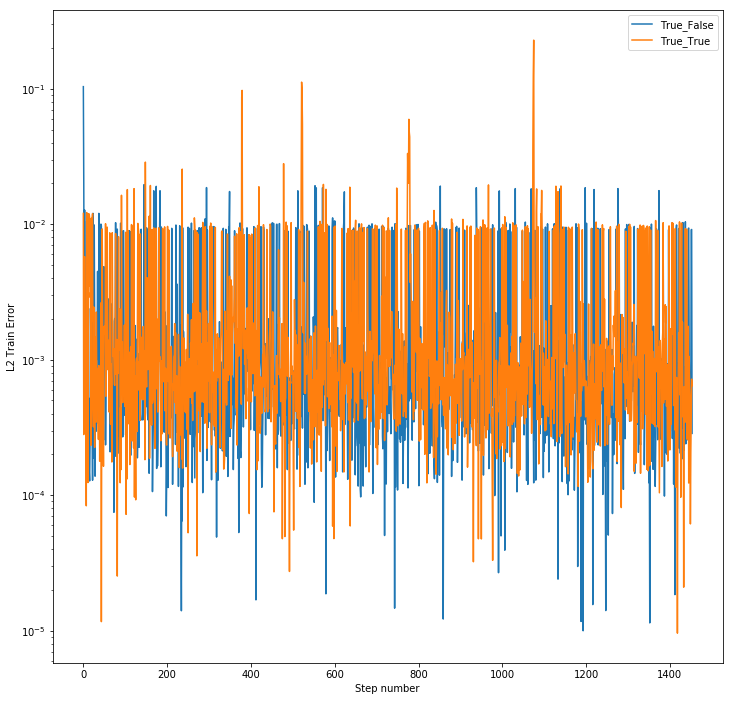

In [85]:
plt.figure(figsize=(12,12))
alpha_channel=1
for N,S in stash.items():
    #plt.semilogy(S['results'][:,1],label=f"{N}, L2")
    plt.semilogy(S['results'][:,1],label=N,alpha=alpha_channel)
    #alpha_channel = 0.25
    #label = None
plt.legend()
#plt.ylim((2e-5,1e-3))
plt.xlabel('Step number')
plt.ylabel('L2 Train Error')
plt.savefig(root+'/paper/burgers_loss.png',dpi=300)
plt.show()

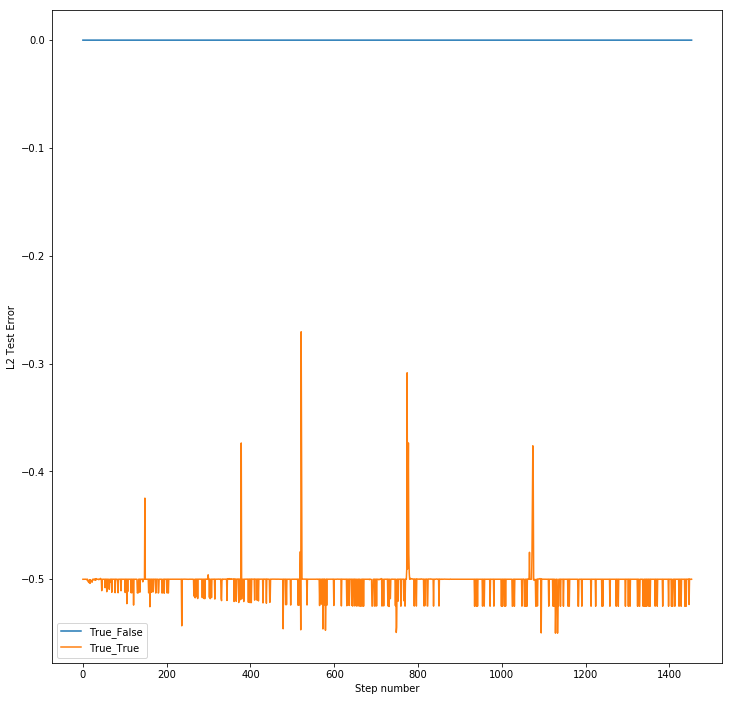

In [86]:
plt.figure(figsize=(12,12))
alpha_channel=1
for N,S in stash.items():
    #plt.semilogy(S['results'][:,1],label=f"{N}, L2")
    plt.plot(S['results'][:,0],label=N,alpha=alpha_channel)
    #alpha_channel = 0.25
    #label = None
plt.legend()
#plt.ylim((2e-5,1e-3))
plt.xlabel('Step number')
plt.ylabel('L2 Test Error')
plt.savefig(root+'/paper/burgers_loss.png',dpi=300)
plt.show()

Trajectory  0


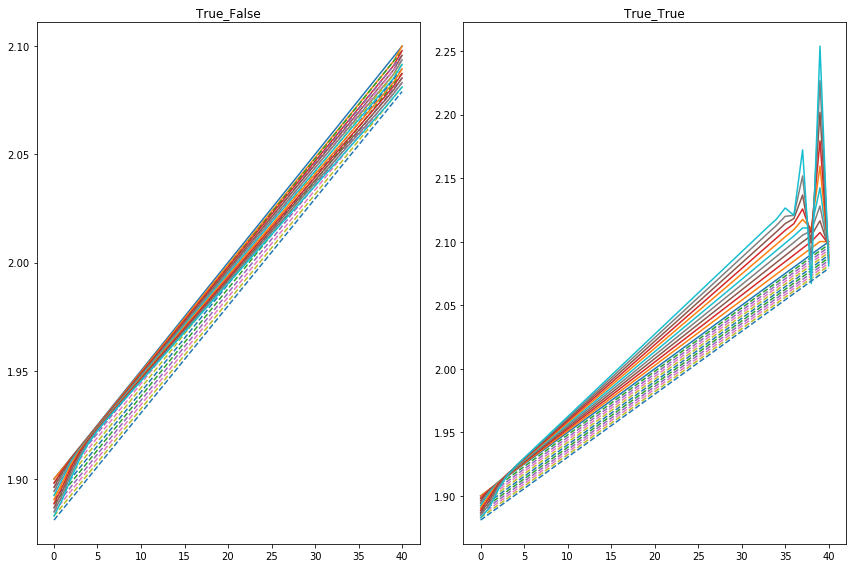

Trajectory  1


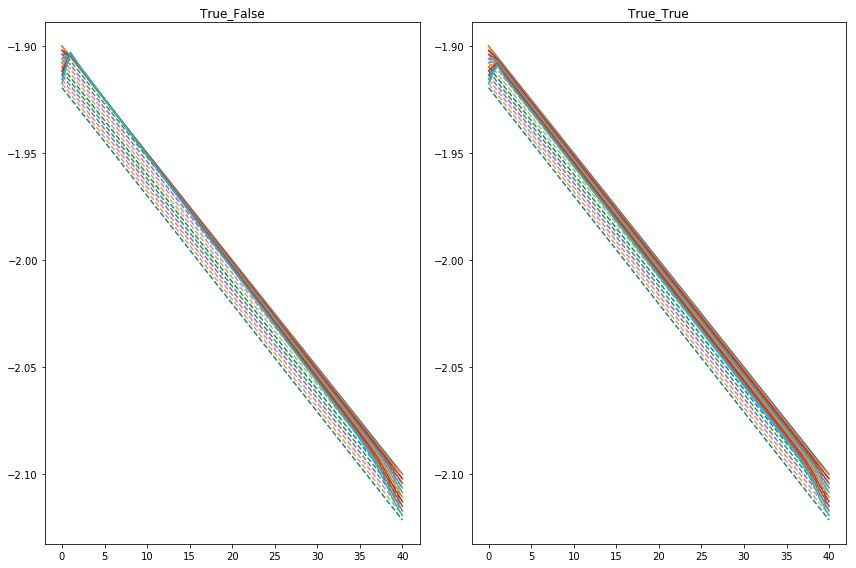

Trajectory  2


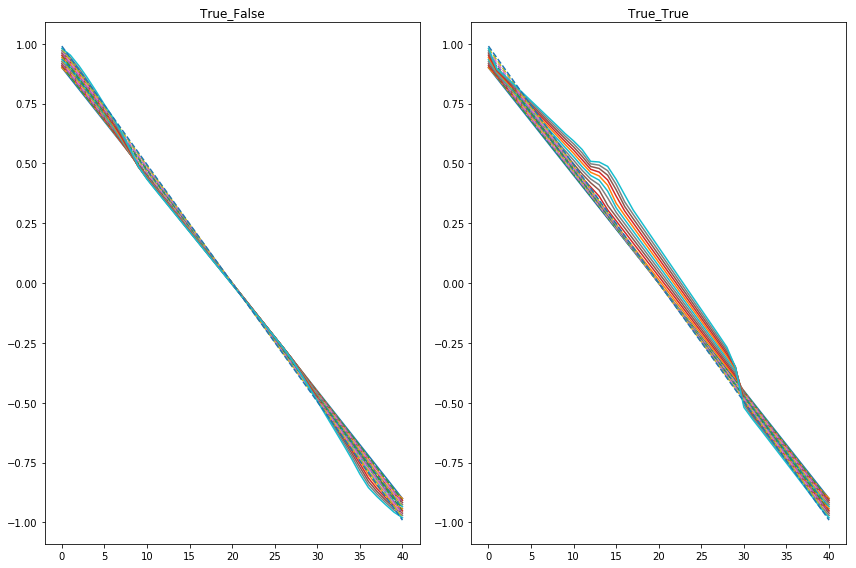

Trajectory  3


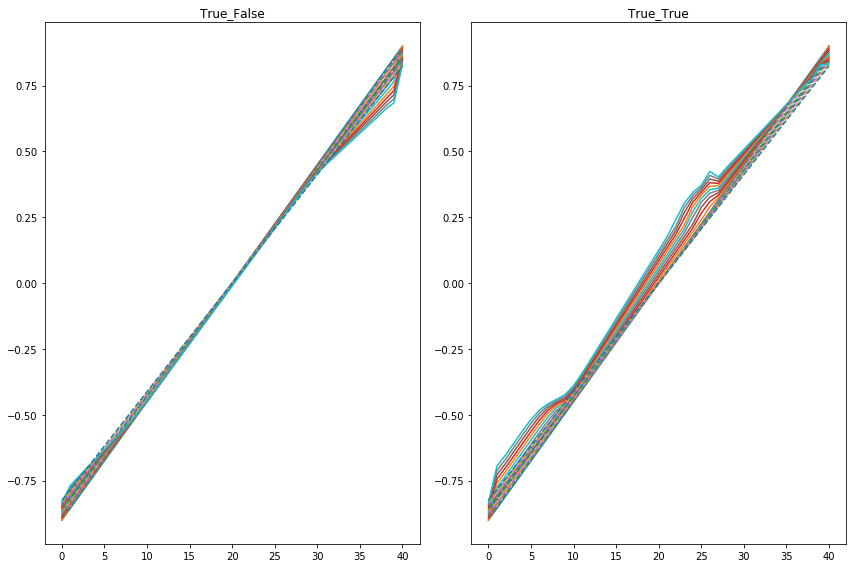

Trajectory  4


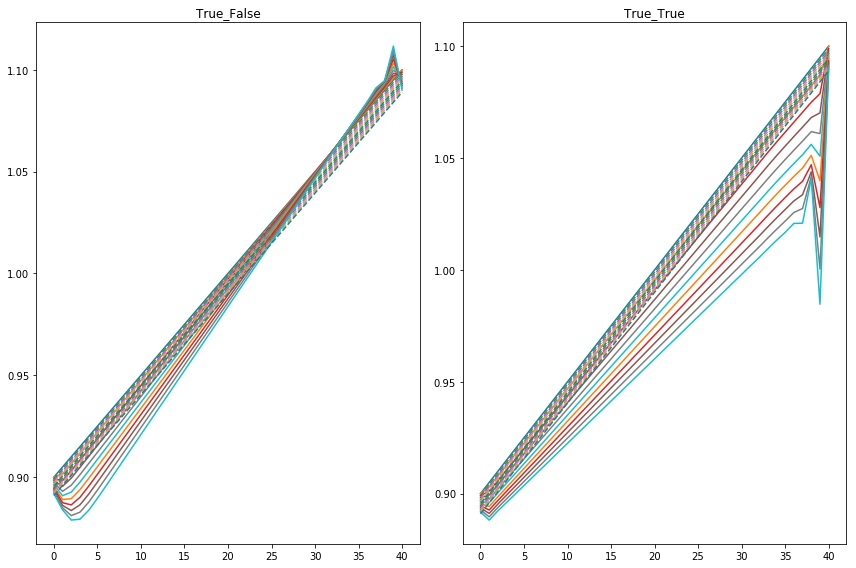

Trajectory  5


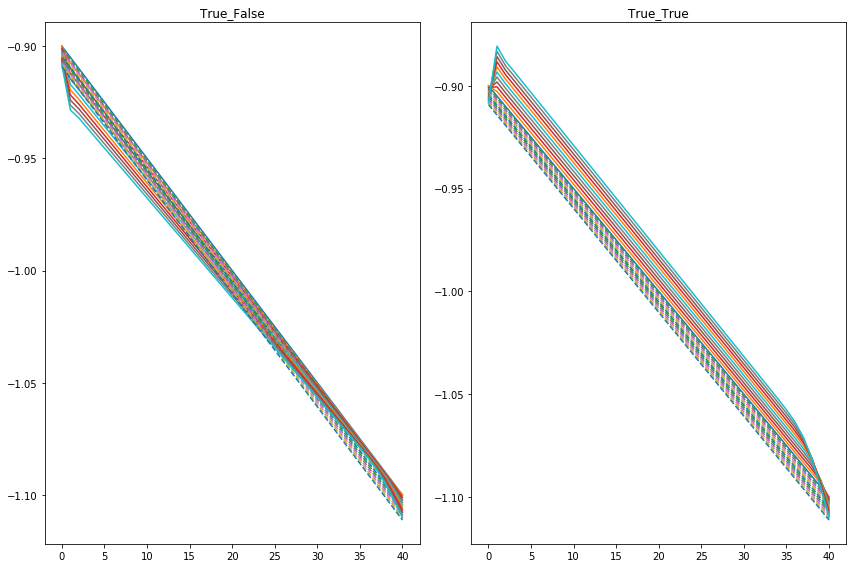

Trajectory  6


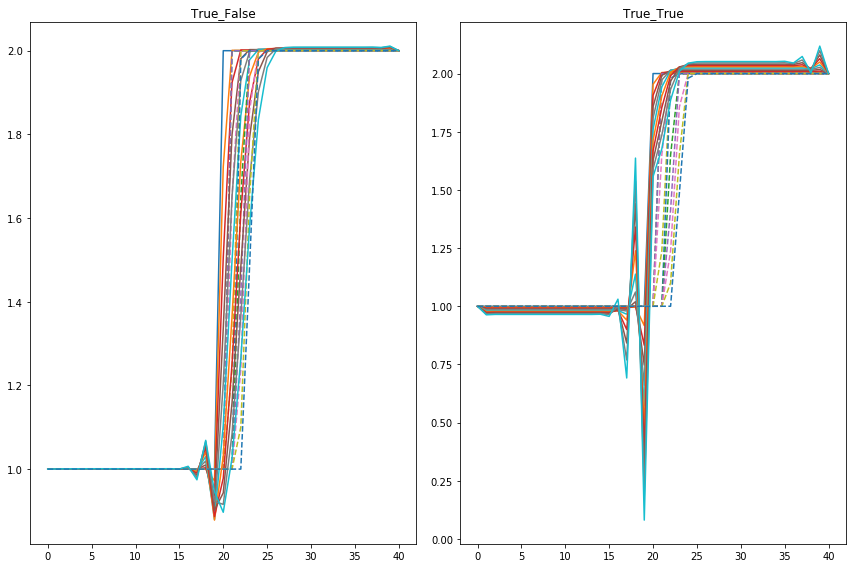

Trajectory  7


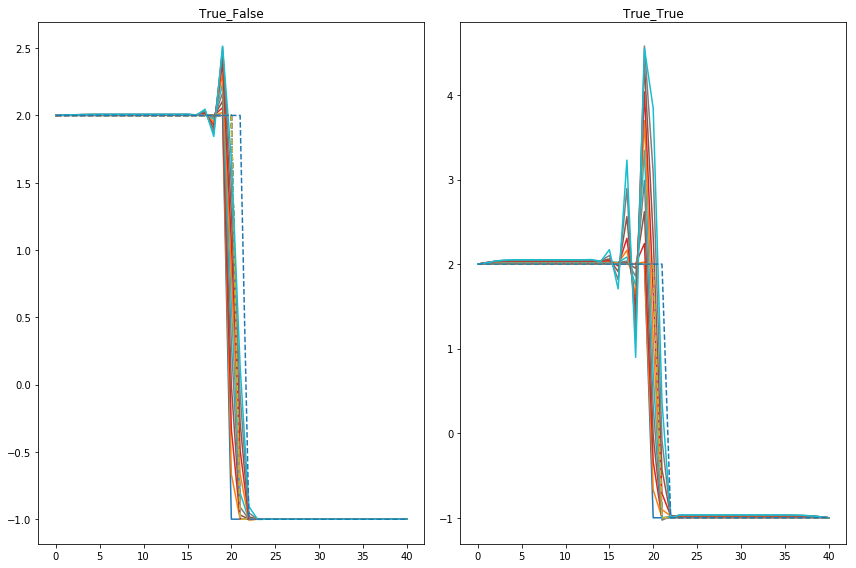

Trajectory  8


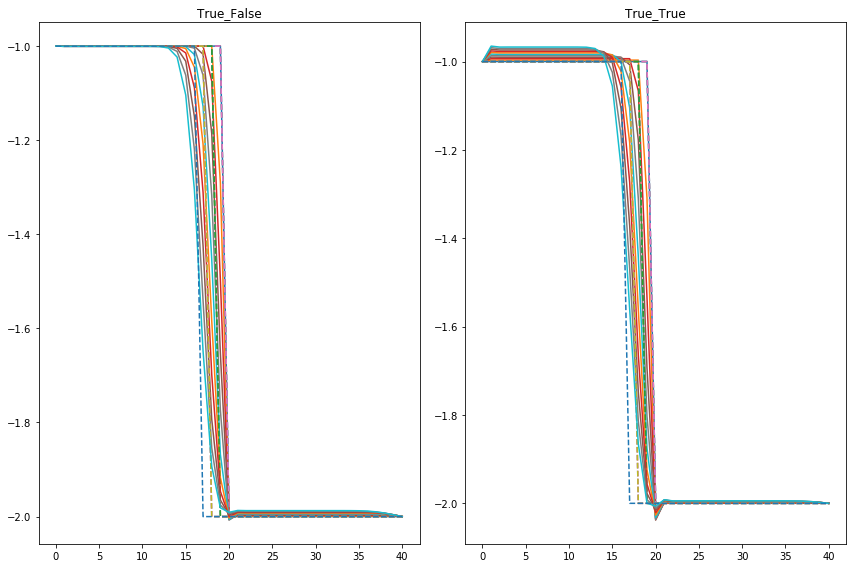

Trajectory  9


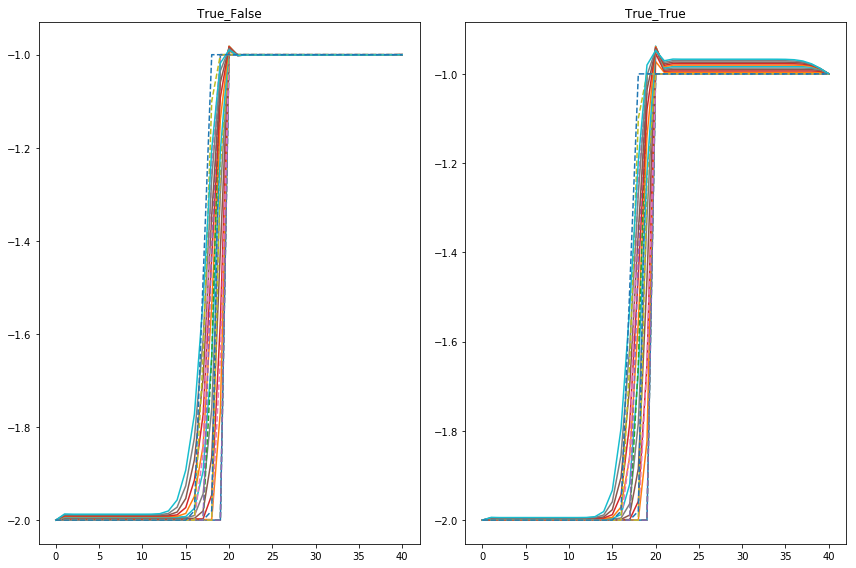

Trajectory  10


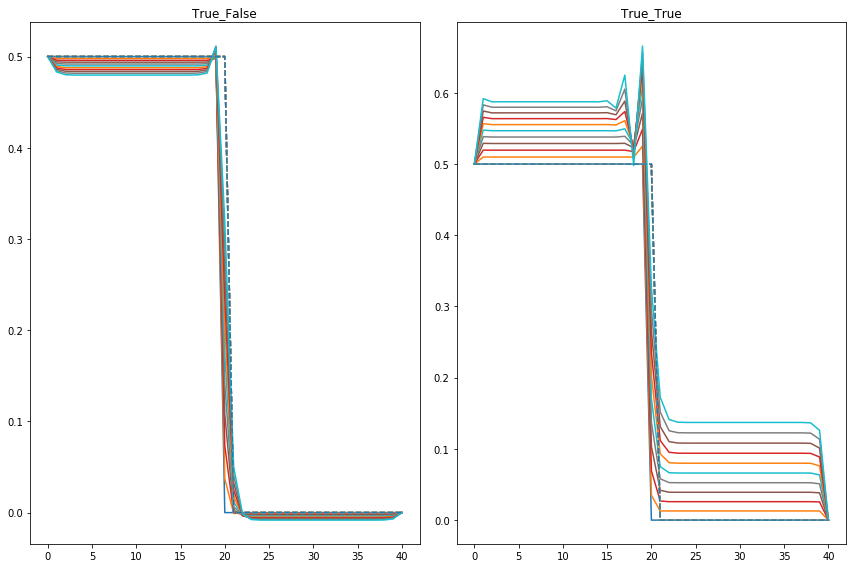

Trajectory  11


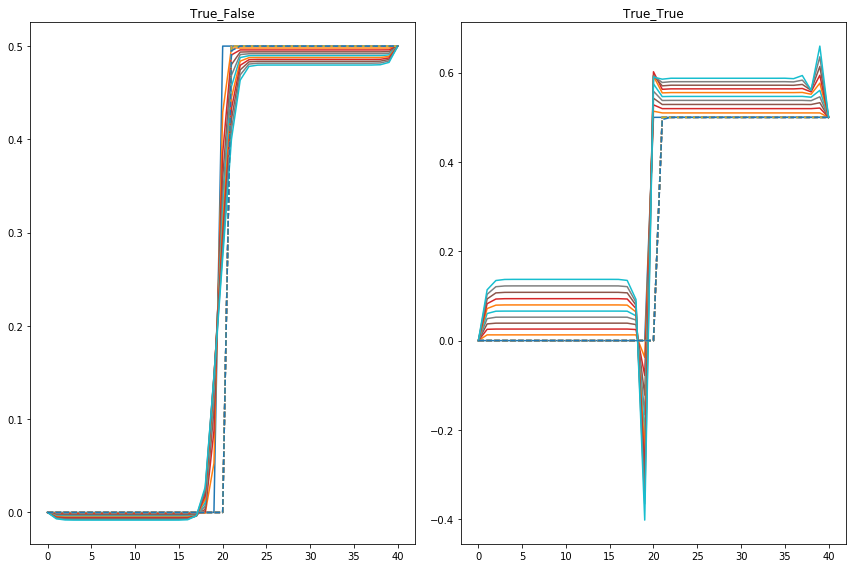

Trajectory  12


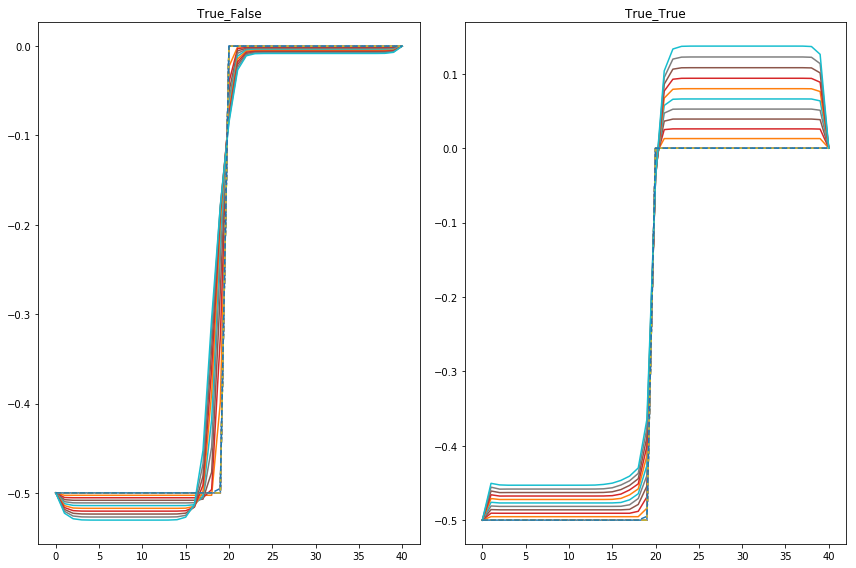

Trajectory  13


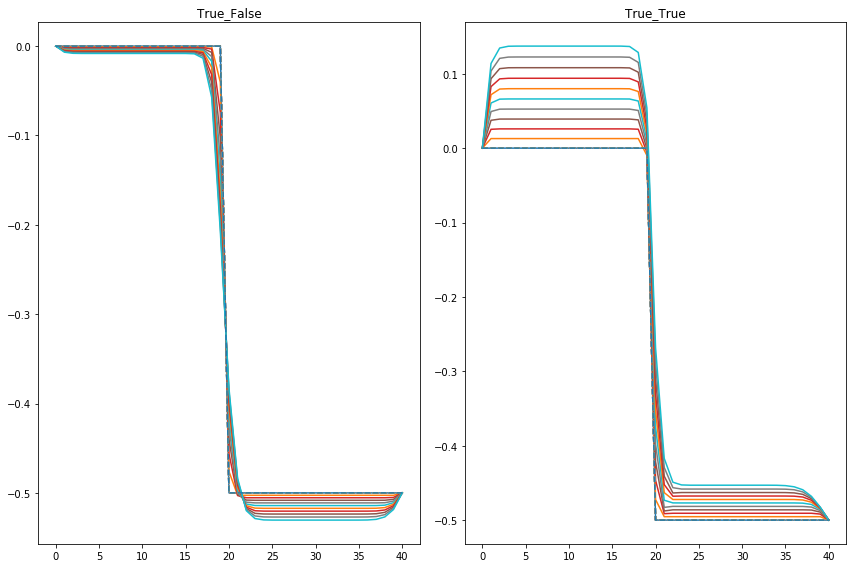

Trajectory  14


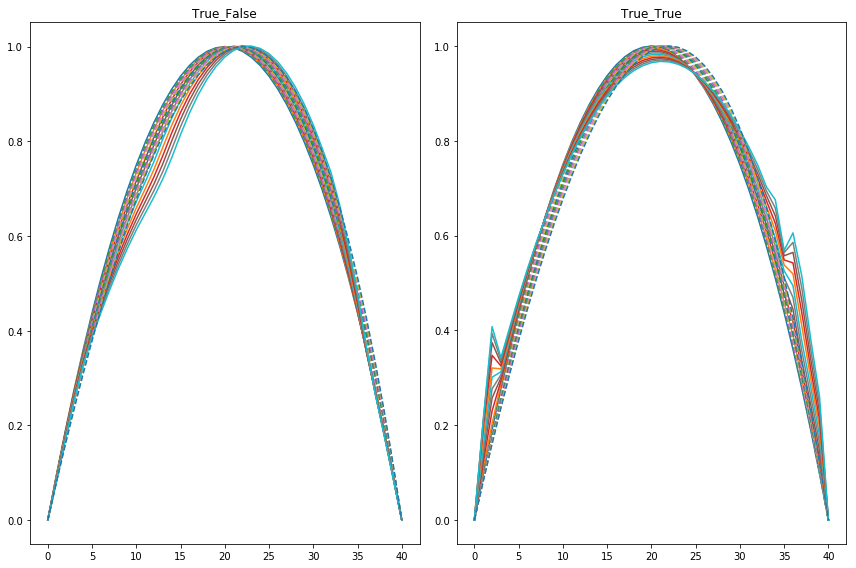

In [91]:
for traj in range(Ntraj): #range(Ntraj-Ntraj_val,Ntraj):
    print("Trajectory ",traj)
    plt.figure(figsize=(12,8))
    err = {}
    for i,(N,S) in enumerate(stash.items()):
        plt.subplot(1,2,i+1)
        err[N] = do_a_path(S['model'],dataset,traj,10)
        plt.title(N)

    #for N,e in err.items():
    #    plt.plot(e,label=N)
    #plt.legend()
    plt.tight_layout()
    plt.show()

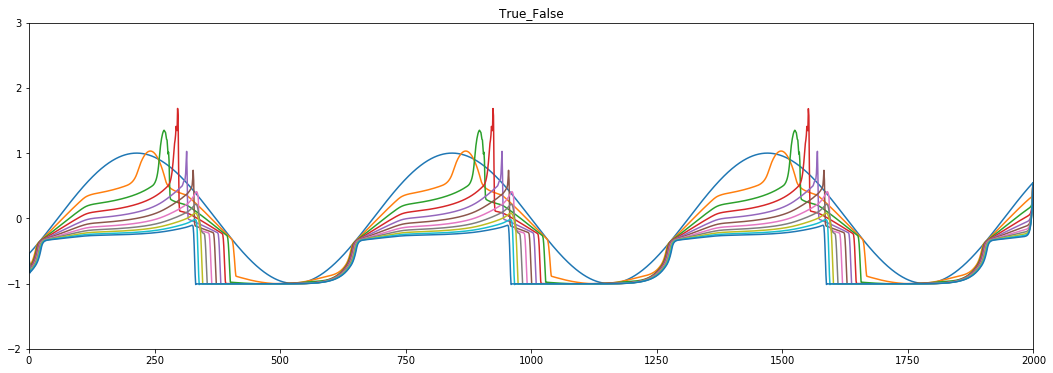

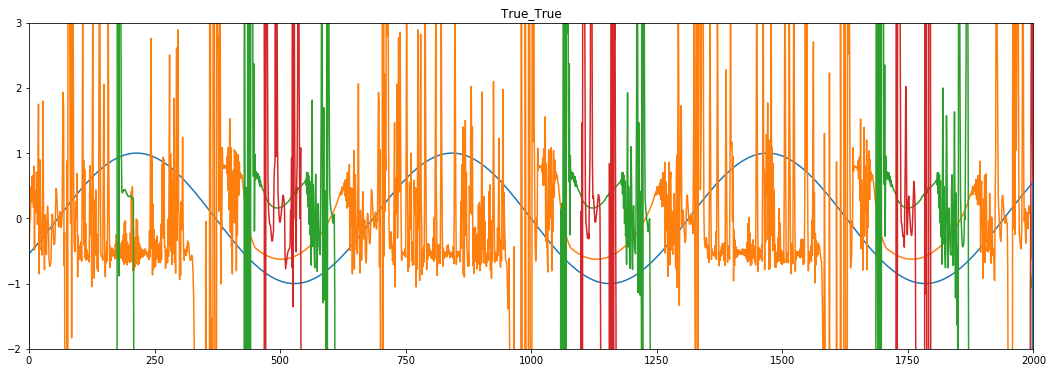

In [92]:
xs = np.linspace(-10,10,2000)
u0 = -np.sin(xs)
for i,(N,S) in enumerate(stash.items()):
    plt.figure(figsize=(18,6))
    plt.ylim((-2,3))
    plt.xlim((0,2000))
    do_an_unknown_path(S['model'], torch.tensor(u0,dtype=torch.float32).to(device), 1000)
    plt.title(N)
    plt.show()

In [93]:
count_parameters(disc)

51